In [27]:
import h5py
import os

import fenics as fe
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

from tqdm import tqdm

import sys
sys.path.insert(0, "../scripts/")

from swe import ShallowOne, ShallowOneLinear

In [28]:
def ds_from_output_file(output_file, field="u"):
    checkpoint = h5py.File(output_file)
    nu = checkpoint["/"].attrs["nu"]
    dt = checkpoint["/"].attrs["dt"]
    linear = checkpoint["/"].attrs["linear"]

    nt_out = checkpoint["/du"].attrs["count"]
    cells = checkpoint["/du/cells"][:]
    nx = cells.shape[0]
    checkpoint.close()

    control = {"nx": nx, "dt": dt, "theta": 0.6, "simulation": "immersed_bump"}
    params = {"nu": nu}
    if linear:
        swe = ShallowOneLinear(control, params)
    else:
        swe = ShallowOne(control, params)

    t = np.zeros((nt_out, ))
    u_out = np.zeros((nt_out, nx + 1))
    h_out = np.zeros((nt_out, nx + 1))

    fe_checkpoint = fe.HDF5File(fe.MPI.comm_world, output_file, "r")
    for i in range(nt_out):
        vec_idx = f"/du/vector_{i}"

        fe_checkpoint.read(swe.du, vec_idx)  # read into du
        u_curr, h_curr = swe.get_vertex_values()

        t[i] = fe_checkpoint.attributes(vec_idx)["timestamp"]
        u_out[i, :] = u_curr
        h_out[i, :] = h_curr

    fe_checkpoint.close()

    coords = swe.x_coords.flatten()
    u_ds = xr.DataArray(data=u_out[:, :, np.newaxis],
                        coords=dict(t=t, x=coords, nu=np.array([nu])),
                        name="u")
    h_ds = xr.DataArray(data=h_out[:, :, np.newaxis],
                        coords=dict(t=t, x=coords, nu=np.array([nu])),
                        name="h")

    if field == "u":
        return u_ds
    elif field == "h":
        return h_ds
    elif field == "both":
        return u_ds, h_ds


In [29]:
# read in all outputs from `output_dir`
output_dir = "../outputs/swe-bump/"
output_files = [output_dir + f for f in os.listdir(output_dir)]
output_files = output_files[::-1]

u_ds = []
h_ds = []
for output_file in tqdm(output_files):
    out = ds_from_output_file(output_file, field="both")

    u_ds.append(out[0])
    h_ds.append(out[1])

# u/h series
du = xr.merge(u_ds)
dh = xr.merge(h_ds)

  0%|                                                                                   | 0/6 [00:00<?, ?it/s]

 17%|████████████▌                                                              | 1/6 [00:01<00:06,  1.30s/it]

 33%|█████████████████████████                                                  | 2/6 [00:02<00:05,  1.30s/it]

 50%|█████████████████████████████████████▌                                     | 3/6 [00:03<00:03,  1.30s/it]

 67%|██████████████████████████████████████████████████                         | 4/6 [00:05<00:02,  1.29s/it]

 83%|██████████████████████████████████████████████████████████████▌            | 5/6 [00:06<00:01,  1.29s/it]

100%|███████████████████████████████████████████████████████████████████████████| 6/6 [00:07<00:00,  1.29s/it]


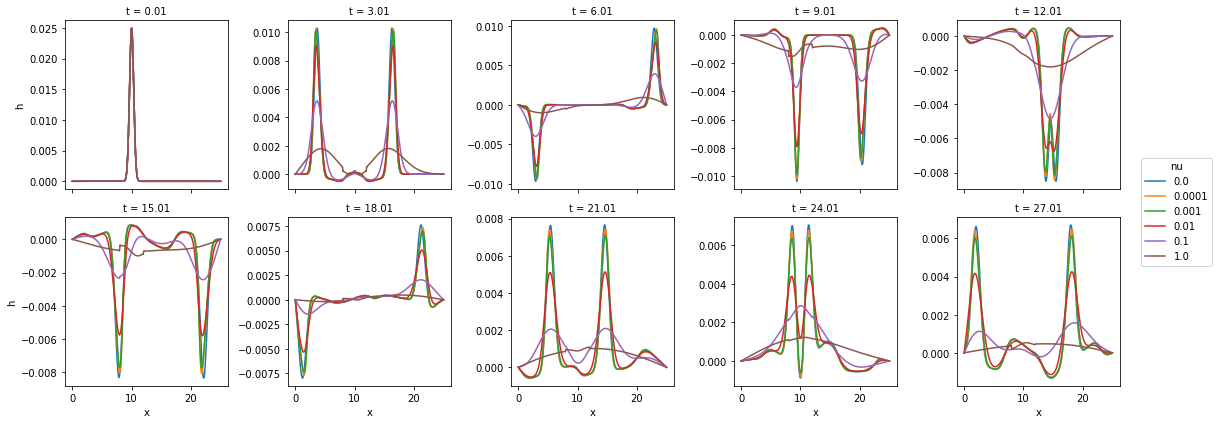

In [19]:
# first we plt to get an idea of dims
dh.h.isel(t=slice(0, 300, 30)).plot(x="x", hue="nu", col="t", col_wrap=5, sharey="none")
plt.show()


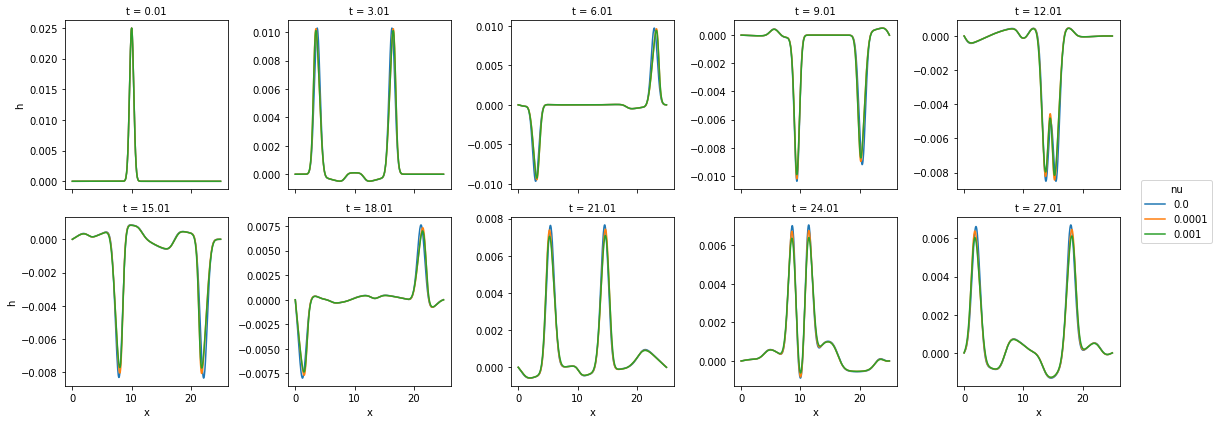

In [23]:
# and zoom in on the first few
dh.h.isel(t=slice(0, 300, 30), nu=slice(0, 3)).plot(
    x="x", hue="nu", col="t", col_wrap=5, sharey="none")
plt.show()

In [24]:
def vector_norm(x, dim, ord=None):
    return xr.apply_ufunc(np.linalg.norm, x,
                          input_core_dims=[[dim]],
                          kwargs={'ord': ord, 'axis': -1})


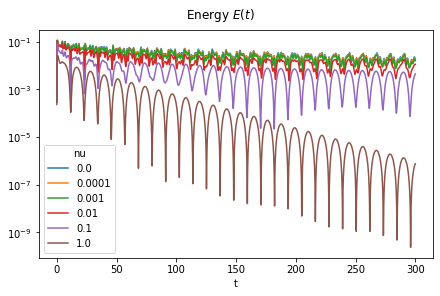

In [25]:
# and we now compute the energy by proxy
fig, ax = plt.subplots(1, 1, constrained_layout=True)
energy = np.power(vector_norm(du, "x", ord=2), 2)
energy.u.plot.line(ax=ax, hue="nu")
ax.set_ylabel("")
ax.set_yscale("log")
fig.suptitle(r"Energy $E(t)$")
plt.show()


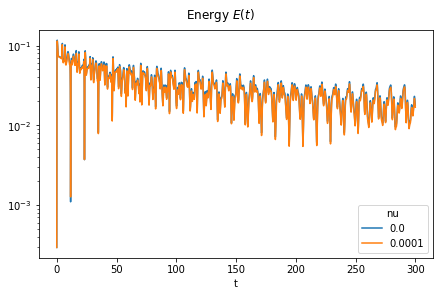

In [26]:
# zoom in on the first few
fig, ax = plt.subplots(1, 1, constrained_layout=True)
energy = np.power(vector_norm(du, "x", ord=2), 2)
energy.u.isel(nu=slice(0, 2)).plot.line(ax=ax, hue="nu")
ax.set_ylabel("")
ax.set_yscale("log")
fig.suptitle(r"Energy $E(t)$")
plt.show()